In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import cross_val_score, KFold
from imblearn.over_sampling import SMOTE
pd.set_option("display.max_columns", None)

### Add Labels to Data

In [70]:
df = pd.read_parquet('Data/Cleaned/more_data_post_feat_engineering.parquet')
labels = pd.read_parquet('Data/Cleaned/more_labels.parquet')

df = df.merge(labels[['GEOID','pred_year','label']], on=['GEOID','pred_year'], how='left')
df

,GEOID,total_pop,percent_hh_income_assist,percent_hh_snap,percent_hh_english,percent_work_agriculture,percent_work_construction,percent_work_retail,percent_work_finance,percent_work_stem,percent_work_edu_health,percent_work_art,percent_out_of_county,percent_moved_within_county,percent_public_transit,percent_drive_commute,percent_bike_commute,percent_walk_commute,percent_wfh,percent_white,percent_black,percent_native,percent_asian,percent_pacific,percent_latino,percent_bachelors,percent_grad,percent_born_citizen,percent_naturalized_citizen,percent_not_citizen,percent_same_house_1yr,percent_out_of_state,med_income,med_rent_acs,med_age,percent_hh_rented,med_value,percent_hh_electric,percent_hh_solar,med_hh_age,med_hh_tenure,num_citibike_rides,num_trees,med_rent,num_affordable_hous_built,num_bikelanes,num_evictions_commercial,num_evictions_residential,park_acres,num_parks,pred_year,lag_vulnerable,label
0,36005000100,-0.068661,0.035685,0.028985,0.001017,0.199477,0.045892,-0.017763,0.035731,0.022690,0.021284,0.054678,-0.014333,0.065448,0.000000,0.000000,0.000000,0.000000,0.000000,-0.006464,0.018035,0.277300,-0.000033,0.000000,-0.024075,-0.124830,0.449510,0.002733,0.025448,0.010323,-0.014150,-0.050057,0.005722,0.049193,0.004397,1.089373,0.008277,-0.005696,12.906525,-0.007878,-0.034566,0.0,0.040565,0.013164,0.000000,0.000000,0.144316,0.082033,0.0,0.0,2020,1.000000,2
1,36005000200,0.034962,0.218237,0.201764,-0.026817,-0.211255,-0.143559,-0.051058,0.005439,0.075584,0.050176,0.071833,-0.077578,-0.105136,0.033405,-0.021183,0.000000,0.138279,-0.377954,0.214509,-0.026615,-0.298942,-0.017225,0.000000,0.009071,0.057625,0.148837,-0.027422,0.023382,0.149468,0.009212,-0.077517,0.030404,-0.003322,0.049306,1.106573,0.001691,0.311270,0.000000,-0.021834,-0.021378,0.0,0.039684,0.000384,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2020,0.689655,0
2,36005000400,0.034124,0.786830,0.168444,-0.006987,0.000000,-0.086546,0.085892,-0.119376,0.065526,-0.033501,0.236460,-0.107590,-0.004790,0.028070,-0.028604,-0.187822,-0.041648,2.037930,0.255629,0.070771,0.083326,-0.038641,0.000000,-0.016291,0.000209,0.032225,0.000973,0.054771,0.012176,0.007979,-0.229897,0.011434,0.009918,0.015270,-0.394797,-0.017437,1.049936,0.000000,-0.060346,-0.014822,0.0,0.065020,-0.002948,0.000000,0.070962,0.000000,0.051681,0.0,0.0,2020,0.620690,0
3,36005001600,0.028238,0.105534,0.119549,-0.037455,0.000000,-0.068067,0.070625,-0.016419,0.270917,-0.013170,0.057567,0.232766,-0.104326,-0.015358,-0.022066,0.000000,0.312918,-0.095215,0.168040,0.005470,0.000000,0.000000,0.000000,0.013476,0.015757,-0.076782,-0.031302,0.045230,0.142282,0.004117,-0.403649,0.008068,0.023547,-0.013855,7.142181,0.003578,0.013124,0.000000,-0.017877,-0.040687,0.0,0.063187,0.029170,0.000000,0.069444,0.000000,0.106212,0.0,0.0,2020,0.743590,1
4,36005001901,0.000644,-0.034693,0.006081,-0.001591,-0.081312,-0.047796,-0.014341,-0.055569,0.035664,-0.007433,0.090601,-0.102033,-0.018727,0.016370,-0.032029,0.232876,0.007768,0.041536,-0.064106,-0.018095,0.106253,-0.061774,0.422531,0.003428,0.049573,0.224663,0.004055,0.049740,-0.004173,0.002864,-0.171264,-0.018268,0.078083,0.001804,7.661378,-0.023169,-0.001365,-0.010289,0.026425,-0.039251,0.0,0.055470,0.016927,-0.520833,0.000000,0.000000,0.048778,0.0,0.0,2020,1.000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11620,36085030302,-0.001154,0.215473,0.011413,-0.021104,0.000000,-0.036738,-0.134240,-0.067538,0.016564,0.077345,0.148286,0.698988,-0.034859,0.041904,-0.004503,0.000000,0.209163,0.946175,-0.045150,0.086675,0.000000,0.011771,0.000000,0.008026,0.055342,0.008809,-0.009526,0.082499,-0.051934,0.002615,-0.173023,0.033478,0.025459,0.025387,-0.050505,0.064139,-0.006120,-0.066851,-0.011909,-0.032434,0.0,0.002710,0.018248,0.000000,0.000000,-1.000000,0.547619,0.0,0.0,2027,0.517241,0
11621,36085031901,0.061577,-0.0407

### Split Data

In [77]:
# Isolate Pred Set
pred_set = df[df.pred_year=='2027']
train_test_set = df[df.pred_year!='2027']

# limit train set to vulnerable/gentrified tracts only
train_test_set = train_test_set[train_test_set.label!=0]
train_test_set.shape

(4195, 53)

In [81]:
# define feature set and split data

feat = ['total_pop', 'percent_hh_income_assist', 'percent_hh_snap',
       'percent_hh_english', 'percent_work_agriculture',
       'percent_work_construction', 'percent_work_retail',
       'percent_work_finance', 'percent_work_stem', 'percent_work_edu_health',
       'percent_work_art', 'percent_out_of_county',
       'percent_moved_within_county', 'percent_public_transit',
       'percent_drive_commute', 'percent_bike_commute', 'percent_walk_commute',
       'percent_wfh', 'percent_white', 'percent_black', 'percent_native',
       'percent_asian', 'percent_pacific', 'percent_latino',
       'percent_bachelors', 'percent_grad', 'percent_born_citizen',
       'percent_naturalized_citizen', 'percent_not_citizen',
       'percent_same_house_1yr', 'percent_out_of_state', 'med_income',
       'med_rent_acs', 'med_age', 'percent_hh_rented', 'med_value',
       'percent_hh_electric', 'percent_hh_solar', 'med_hh_age',
       'med_hh_tenure', 'num_citibike_rides', 'num_trees', 'med_rent',
       'num_affordable_hous_built', 'num_bikelanes',
       'num_evictions_commercial', 'num_evictions_residential', 'park_acres',
       'num_parks', 'lag_vulnerable']

# split the data by census tracts to avoid leakage
test_size = int(train_test_set.shape[0] * .2)
test_ids = train_test_set.GEOID.sample(test_size)  
test = train_test_set[train_test_set.GEOID.isin(test_ids)]
train = train_test_set[train_test_set.GEOID.isin(test_ids) ==False]

y = train_test_set['label']
y_train = train['label']
y_test = test['label']

X = train_test_set[feat]
X_train = train[feat]
X_test = test[feat]

# Apply SMOTE to the training data to upsample minority class
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)


In [83]:
# Random Forest

forest = RandomForestClassifier(n_estimators=100)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

kf = KFold(n_splits=5, shuffle=True)
cv_scores = cross_val_score(forest, X, y, cv=kf,scoring="f1")
print("CV Scores:", cv_scores)
print("Mean F1:", np.mean(cv_scores))


# train_score = accuracy_score(y_train, y_train_pred)
# test_score =  accuracy_score(y_test, y_test_pred)
# print("Train Precision:", train_score)
# print("Test Precision:", test_score)

CV Scores: [0.8458498  0.859375   0.84115884 0.8590998  0.86854917]
Mean F1: 0.8548065240364615


In [74]:
# logreg = LogisticRegression()
# logreg.fit(X_train, y_train)
# y_train_pred = logreg.predict(X_train)
# y_test_pred = logreg.predict(X_test)

# kf = KFold(n_splits=5, shuffle=True)
# cv_scores = cross_val_score(logreg, X, y, cv=kf, scoring="f1")
# print("CV Scores:", cv_scores)
# print("Mean F1:", np.mean(cv_scores))




# train_score = accuracy_score(y_train, y_train_pred)
# test_score =  accuracy_score(y_test, y_test_pred)
# print("Train Precision:", train_score)
# print("Test Precision:", test_score)


In [75]:
sorted(list(zip(forest.feature_importances_, X_train.columns)), reverse=True)

[(0.0821940358906587, 'percent_grad'),
 (0.06296953092831604, 'med_income'),
 (0.03331669546770121, 'percent_bachelors'),
 (0.027915199111907322, 'percent_public_transit'),
 (0.02522887044573948, 'med_rent_acs'),
 (0.023964268564642906, 'med_rent'),
 (0.02367533187595991, 'percent_asian'),
 (0.02324864992089743, 'percent_naturalized_citizen'),
 (0.022093099365280252, 'med_age'),
 (0.022031450731828866, 'percent_white'),
 (0.021249680508277028, 'med_value'),
 (0.021239638943327047, 'percent_hh_electric'),
 (0.020428286213909182, 'percent_out_of_state'),
 (0.020427414211005662, 'num_trees'),
 (0.020202334787817123, 'percent_hh_snap'),
 (0.020130196723184314, 'percent_hh_english'),
 (0.02002996739340343, 'percent_work_art'),
 (0.019957780173810374, 'percent_work_edu_health'),
 (0.01988664891802665, 'percent_latino'),
 (0.01969303156027149, 'med_hh_age'),
 (0.019606233177911436, 'total_pop'),
 (0.019593091407143954, 'med_hh_tenure'),
 (0.01953419138966489, 'percent_out_of_county'),
 (0.019

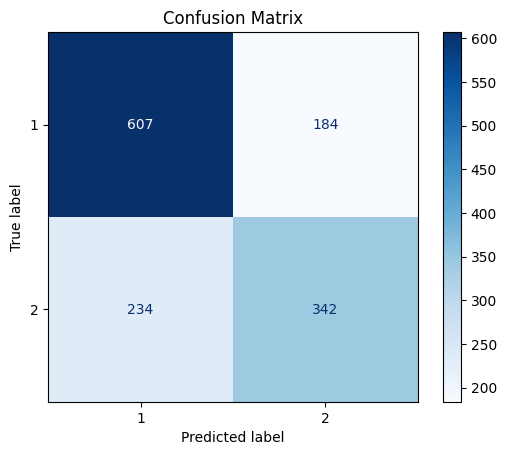

In [76]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test['label'].unique())
disp.plot(cmap=plt.cm.Blues)

# Show the plot
plt.title("Confusion Matrix")
plt.show()